In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset,DataLoader
import time
%matplotlib inline

In [2]:
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp,cmap)

In [3]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

In [4]:
simple_transform = transforms.Compose([transforms.Resize((224,224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('data/train/',simple_transform)
valid = ImageFolder('data/valid/',simple_transform)

In [5]:
print(train.class_to_idx)
print(train.classes) 

{'cat': 0, 'dog': 1}
['cat', 'dog']


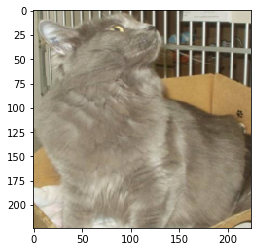

In [6]:
imshow(valid[770][0])

In [7]:
train_data_loader = torch.utils.data.DataLoader(train,batch_size=32,num_workers=3,shuffle=True)
valid_data_loader = torch.utils.data.DataLoader(valid,batch_size=32,num_workers=3,shuffle=True)

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(56180, 500)
        self.fc2 = nn.Linear(500,50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x,training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x,dim=1)

In [9]:
model = Net()
if is_cuda:
    model.cuda()

In [10]:
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.5)

In [13]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        if is_cuda:
            data,target = data.cuda(),target.cuda()
        data , target = Variable(data,volatile),Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print(f'{phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}')
    return loss,accuracy

In [ ]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]
for epoch in range(1,20):
    epoch_loss, epoch_accuracy = fit(epoch,model,train_data_loader,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,valid_data_loader,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training loss is  0.67 and training accuracy is 13562/23000     58.97
validation loss is  0.62 and validation accuracy is 1330/2000      66.5
training loss is  0.62 and training accuracy is 14981/23000     65.13


In [1]:
plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
plt.legend()

NameError: name 'plt' is not defined

In [ ]:
plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'bo',label = 'train accuracy')
plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'val accuracy')
plt.legend()
